## Import Libraries

In [6]:
from langgraph.graph import StateGraph, START, END 
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

# Load environment variables
load_dotenv()
MODEL = "gpt-4.1-mini"
TEMPERATURE = 0

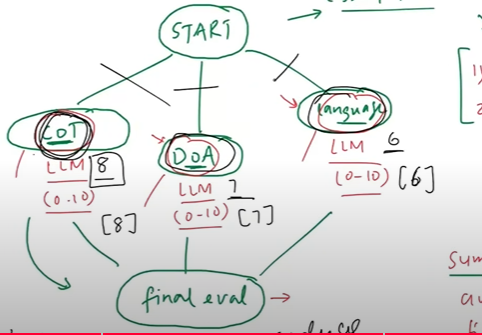

## Structured Model

In [ ]:
# Create LLM Instance
model = ChatOpenAI(model=MODEL, temperature=TEMPERATURE)

# Define Schema
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="Concise feedback on the essay")
    score: float = Field(description="Score between 0 and 10", ge=0, le=10)


# Create Structured Model
structured_model = model.with_structured_output(EvaluationSchema)

In [15]:
# Test the structured output
essay = "Once upon a time, there was a brave knight..."

prompt = f"""Evaluate the following essay and provide feedback and a score between 0 and 10.
Essay: {essay}
"""

structured_model.invoke(prompt)

EvaluationSchema(feedback='The essay begins with a classic and engaging opening, setting the stage for a story about a brave knight. However, it is very brief and lacks development, detail, and a clear narrative arc. Expanding on the plot, characters, and setting would greatly improve the essay.', score=3.0)

In [11]:
# define state

class UAFState(TypedDict):
    essay: str
    
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str

    overall_feedback: str

    individual_scores: Annotated[list[int], operator.add] 
    average_score: float

In [24]:
# define functions

def evaluate_clarity(state: UAFState) -> UAFState:
    
    prompt = f"""Evaluate the clarity of the following essay and provide feedback and a score between 0 and 10.
            Essay: {state['essay']}
            """
    result = structured_model.invoke(prompt)
    clarity_feedback = result.feedback
    clarity_score = [result.score]

    return {'clarity_feedback': clarity_feedback, 'individual_scores': clarity_score}


def evaluate_analysis(state: UAFState) -> UAFState:
    
    prompt = f"""Evaluate the analysis of the following essay and provide feedback and a score between 0 and 10.
            Essay: {state['essay']}
            """
    result = structured_model.invoke(prompt)
    analysis_feedback = result.feedback
    analysis_score = [result.score]

    return {'analysis_feedback': analysis_feedback, 'individual_scores': analysis_score}


def evaluate_language(state: UAFState) -> UAFState:
    
    prompt = f"""Evaluate the language of the following essay and provide feedback and a score between 0 and 10.
            Essay: {state['essay']}
            """
    result = structured_model.invoke(prompt)
    language_feedback = result.feedback
    language_score = [result.score]

    return {'language_feedback': language_feedback, 'individual_scores': language_score}


def overall_feedback(state: UAFState) -> UAFState:
    
    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])

    prompt = f"""Provide overall feedback for the following essay based on the individual feedbacks.
            Essay: {state['essay']}
            Language Feedback: {state['language_feedback']}
            Analysis Feedback: {state['analysis_feedback']}
            Clarity Feedback: {state['clarity_feedback']}
            Average Score: {avg_score}
            """
    result = model.invoke(prompt)
    overall_fb = result.content

    return {'overall_feedback': overall_fb, 'average_score': avg_score}

In [25]:
# define graph

graph = StateGraph(UAFState)

# add notes
graph.add_node("evaluate_clarity", evaluate_clarity)
graph.add_node("evaluate_analysis", evaluate_analysis)
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("overall_feedback", overall_feedback)

# add edges
graph.add_edge(START, "evaluate_clarity")
graph.add_edge(START, "evaluate_analysis")
graph.add_edge(START, "evaluate_language")

graph.add_edge("evaluate_clarity", "overall_feedback")
graph.add_edge("evaluate_analysis", "overall_feedback")
graph.add_edge("evaluate_language", "overall_feedback")

graph.add_edge("overall_feedback", END)


# compile graph
workflow = graph.compile()

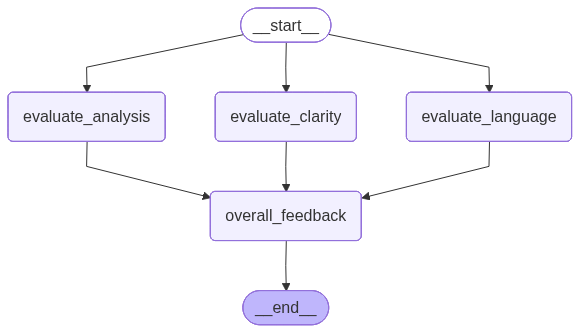

In [26]:
workflow

In [27]:
# execute graph
essay = "Once upon a time, there was a brave knight..."
initial_state = {'essay': essay}

final_state = workflow.invoke(initial_state)

In [29]:
from pprint import pprint
pprint(final_state)

{'analysis_feedback': 'The analysis is missing; no evaluation or insights '
                      'about the essay were provided. To improve, include a '
                      'clear summary, critique, and interpretation of the '
                      "essay's themes, structure, and style.",
 'average_score': 2.0,
 'clarity_feedback': 'The essay begins with a classic and clear opening, '
                     'setting the stage for a story about a brave knight. '
                     'However, since the provided text is very brief and lacks '
                     'further development, the clarity of the overall essay '
                     'cannot be fully assessed. More content is needed to '
                     'evaluate the clarity comprehensively.',
 'essay': 'Once upon a time, there was a brave knight...',
 'individual_scores': [0.0, 3.0, 3.0],
 'language_feedback': 'The essay begins with a classic and engaging opening '
                      'phrase, setting a fairy-tale tone. Ho